## This code trains an encoder/decoder for 1 channel of the pnnl datasets.

Make sure the channel is set:

channel = 0,1,2,3 = velocity_x, velocity_y, volume_frac, pressure

train/test sets can be any ordering of these. 

trainSims = ['001', '050']

testSims = ['025']


## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, convertSimToImage, pkl_save, pkl_load

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "pnnl_plateau_train"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "1"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
dataDirec = '/data/ccsi/PNNLTimeStepData/'
channel = 1
gridSize = 128
interpMethod = 'linear'
trainSims = ['001', '050']
testSims = ['025']
preprocess = False # keep this as false until using the long runtime loader

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  

# hyper-params
seed = 1234
np.random.seed(seed)
bz = 16
numSamplesToKeep = np.infty #if not debugging
latentDim = 1000
filters = 128
num_conv = 2 # breaks when less than 2
simLen = 500
stack = True
doJacobian = False
createStreamFcn = False
repeat = 0
skip_connection = False
patience = 2
if DEBUG:
    epochs = 2
    numSamplesToKeep = bz
    
versionName = versionName + '_channel{}_gridSize{}_latentDim{}_filters{}_bz{}_numConv{}_jacobian{}_epochs{}_stack{}'.format(channel,gridSize,latentDim,filters,bz,num_conv,doJacobian,epochs,stack)
versionName

'pnnl_plateau_train_GPUs1_channel1_gridSize128_latentDim1000_filters128_bz16_numConv2_jacobianFalse_epochs1000_stackTrue'

### Select Personal GPUs

In [ ]:
!nvidia-smi

Sun Sep 20 15:13:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |   2571MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |     11MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Sun Sep 20 15:14:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |   2571MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   21C    P2    59W / 250W |    510MiB / 12196MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [ ]:
# get the training data
data = []
for s in trainSims:
    print(s)
    fn = os.path.join(dataDirec,'data_{}x{}_{}'.format(gridSize,gridSize,interpMethod),s+'.pkl')
    D = CCSI_2D(fn,preprocess=preprocess,channel=channel)
    dl = DataLoader(D,batch_size=len(D))
    X,X = next(iter(dl))
    data.append(X)
data = np.concatenate(data)
print(data.shape, D.grid_x.shape, D.grid_y.shape)
trainDataset = {'data':data, 'grid_x':D.grid_x, 'grid_y':D.grid_y}
pkl_save(trainDataset,'tmp.pkl')
trainDataset = CCSI_2D('tmp.pkl',numToKeep=numSamplesToKeep, preprocess=preprocess) 
len(trainDataset)

001
050
(1000, 1, 128, 128) (128, 128) (128, 128)


1000

In [ ]:
# get the test data
fn = os.path.join(dataDirec,'data_{}x{}_{}'.format(gridSize,gridSize,interpMethod),testSims[0]+'.pkl')
testDataset =  CCSI_2D(fn,preprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel)
len(testDataset)

500

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)
len(trainDataLoader), len(testDataLoader)

(62, 32)

## Model

Currently, the models need to take data to be built. It's kinda weird. I may look into fix this later. 

In [ ]:
X,X = next(iter(trainDataLoader))
X = X.to(device)
X.shape

torch.Size([16, 1, 128, 128])

In [ ]:
model = AE_xhat_zV2(X, filters, latentDim, num_conv, repeat, 
                 skip_connection, stack, conv_k=3, last_k=3, 
                 act=nn.LeakyReLU(), return_z=True, stream=createStreamFcn, device=device)

if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [ ]:
printNumModelParams(model)

82 layers require gradients (unfrozen) out of 82 layers
26,253,545 parameters require gradients (unfrozen) out of 26,253,545 parameters


In [ ]:
Xhat,z = model(X)
Xhat.shape, z.shape

(torch.Size([16, 1, 128, 128]), torch.Size([16, 1000]))

## Loss Function

In [ ]:
def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    
    if createStreamFcn:
        pred = stream2uv(pred, device)
        
    L1 = L1_loss(pred, target)
    Lj = 0
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
        
    return L1 + Lj

In [ ]:
pred = stream2uv(Xhat,device)
pred.shape

torch.Size([16, 2, 128, 128])

In [ ]:
loss(pred,X,device)

tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)

## Set LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


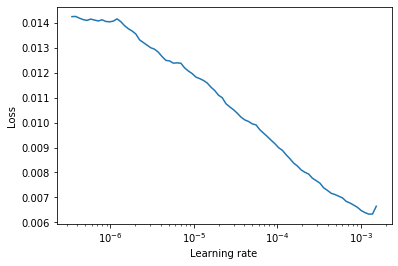

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    model.return_z = False
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,trainDataLoader)
    model.return_z = True

In [ ]:
max_lr = .0001
start_lr = 5*max_lr/10
#opt = create_opt(max_lr,model)
#lr_scheduler = create_one_cycle(opt,max_lr,epochs,trainDataLoader)
opt = torch.optim.Adam(model.parameters(),lr=max_lr,betas=(.5,.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [ ]:
versionName = versionName + '_lr{}'.format(str(max_lr))

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        #X,p = sampleBatch[0],sampleBatch[1]
        X = sampleBatch[0]
        X = X.to(device)
        #p = p.to(device)

        # zero the parameter gradients
        opt.zero_grad()

        X_hat, z = model(X)
        #pl = p_loss(z,p)
        ll = loss(X_hat,X,device)
        combined_loss = ll #pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss
        
        #batch_ploss = pl.item()
        #running_ploss += batch_ploss

        # --- Metrics Recording ---

        # metrics
        r = metric(X_hat, X)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)
        #lr_scheduler.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            #avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            #tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            #running_ploss = 0.0

    return total_loss, tensorboard_recorder_step, total_steps

In [ ]:
# EXPORT
def validEpoch(myDataLoader, tensorboard_writer, model, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        #X,p = sampleBatch[0],sampleBatch[1]
        X = sampleBatch[0]
        X = X.to(device)
        #p = p.to(device)
        
        perc = len(X)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            X_hat, z = model(X)

        # loss
        #combined_loss = p_loss(z,p) + loss(X_hat,X,device)
        combined_loss = loss(X_hat,X,device)
        
        running_loss += perc*(combined_loss.item())

        # metrics
        r = metric(X_hat, X)
        running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, p_loss, loss,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#     if trainLoss < bestLoss:
#         bestLoss = trainLoss
#         writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#         torch.save(model.state_dict(), os.path.join(cps,versionName))
        
    model.eval()
    valLoss = validEpoch(testDataLoader, test_writer, model, p_loss, loss, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)
    
    # checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))

    lr_scheduler.step(trainLoss)
    
    if opt.param_groups[0]['lr'] < 5e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---
trainLoss: 3.0188e+00
LR: 1.0000e-04
valLoss: 4.1003e-02
Better valLoss: 4.1003e-02, Saving models...


  0%|          | 1/1000 [00:12<3:31:07, 12.68s/it]

--- Epoch 2/1000 ---
trainLoss: 2.1769e+00
LR: 1.0000e-04
valLoss: 3.2036e-02
Better valLoss: 3.2036e-02, Saving models...


  0%|          | 2/1000 [00:25<3:31:00, 12.69s/it]

--- Epoch 3/1000 ---
trainLoss: 1.9314e+00
LR: 1.0000e-04
valLoss: 2.8456e-02
Better valLoss: 2.8456e-02, Saving models...


  0%|          | 3/1000 [00:38<3:31:06, 12.70s/it]

--- Epoch 4/1000 ---
trainLoss: 1.7821e+00
LR: 1.0000e-04
valLoss: 2.5897e-02
Better valLoss: 2.5897e-02, Saving models...


  0%|          | 4/1000 [00:50<3:31:12, 12.72s/it]

--- Epoch 5/1000 ---
trainLoss: 1.6610e+00
LR: 1.0000e-04
valLoss: 2.4035e-02
Better valLoss: 2.4035e-02, Saving models...


  0%|          | 5/1000 [01:03<3:31:14, 12.74s/it]

--- Epoch 6/1000 ---
trainLoss: 1.5333e+00
LR: 1.0000e-04
valLoss: 2.2464e-02
Better valLoss: 2.2464e-02, Saving models...


  1%|          | 6/1000 [01:16<3:31:21, 12.76s/it]

--- Epoch 7/1000 ---
trainLoss: 1.5010e+00
LR: 1.0000e-04


  1%|          | 7/1000 [01:29<3:30:22, 12.71s/it]

valLoss: 2.5446e-02
--- Epoch 8/1000 ---
trainLoss: 1.5571e+00
LR: 1.0000e-04


  1%|          | 8/1000 [01:41<3:29:34, 12.68s/it]

valLoss: 4.5678e-02
--- Epoch 9/1000 ---
trainLoss: 4.7330e+00
LR: 1.0000e-04


  1%|          | 9/1000 [01:54<3:29:01, 12.66s/it]

valLoss: 2.9261e-02
--- Epoch 10/1000 ---
trainLoss: 1.7262e+00
LR: 1.0000e-04


  1%|          | 10/1000 [02:06<3:28:40, 12.65s/it]

valLoss: 2.6735e-02
--- Epoch 11/1000 ---
trainLoss: 1.5513e+00
LR: 1.0000e-05


  1%|          | 11/1000 [02:19<3:28:21, 12.64s/it]

valLoss: 2.4013e-02
--- Epoch 12/1000 ---
trainLoss: 1.5070e+00
LR: 1.0000e-05


  1%|          | 12/1000 [02:32<3:28:08, 12.64s/it]

valLoss: 2.3512e-02
--- Epoch 13/1000 ---
trainLoss: 1.4710e+00
LR: 1.0000e-05


  1%|▏         | 13/1000 [02:44<3:27:52, 12.64s/it]

valLoss: 2.2966e-02
--- Epoch 14/1000 ---
trainLoss: 1.4378e+00
LR: 1.0000e-05
valLoss: 2.2348e-02
Better valLoss: 2.2348e-02, Saving models...


  1%|▏         | 14/1000 [02:57<3:28:57, 12.72s/it]

--- Epoch 15/1000 ---
trainLoss: 1.4026e+00
LR: 1.0000e-05
valLoss: 2.1758e-02
Better valLoss: 2.1758e-02, Saving models...


  2%|▏         | 15/1000 [03:10<3:29:33, 12.77s/it]

--- Epoch 16/1000 ---
trainLoss: 1.3744e+00
LR: 1.0000e-05
valLoss: 2.1334e-02
Better valLoss: 2.1334e-02, Saving models...


  2%|▏         | 16/1000 [03:23<3:29:56, 12.80s/it]

--- Epoch 17/1000 ---
trainLoss: 1.3472e+00
LR: 1.0000e-05
valLoss: 2.0879e-02
Better valLoss: 2.0879e-02, Saving models...


  2%|▏         | 17/1000 [03:36<3:30:12, 12.83s/it]

--- Epoch 18/1000 ---
trainLoss: 1.3264e+00
LR: 1.0000e-05
valLoss: 2.0448e-02
Better valLoss: 2.0448e-02, Saving models...


  2%|▏         | 18/1000 [03:49<3:30:24, 12.86s/it]

--- Epoch 19/1000 ---
trainLoss: 1.3016e+00
LR: 1.0000e-05
valLoss: 2.0183e-02
Better valLoss: 2.0183e-02, Saving models...


  2%|▏         | 19/1000 [04:02<3:30:27, 12.87s/it]

--- Epoch 20/1000 ---
trainLoss: 1.2696e+00
LR: 1.0000e-05
valLoss: 1.9809e-02
Better valLoss: 1.9809e-02, Saving models...


  2%|▏         | 20/1000 [04:15<3:30:29, 12.89s/it]

--- Epoch 21/1000 ---
trainLoss: 1.2527e+00
LR: 1.0000e-05
valLoss: 1.9468e-02
Better valLoss: 1.9468e-02, Saving models...


  2%|▏         | 21/1000 [04:28<3:30:26, 12.90s/it]

--- Epoch 22/1000 ---
trainLoss: 1.2313e+00
LR: 1.0000e-05
valLoss: 1.9157e-02
Better valLoss: 1.9157e-02, Saving models...


  2%|▏         | 22/1000 [04:40<3:30:21, 12.91s/it]

--- Epoch 23/1000 ---
trainLoss: 1.2141e+00
LR: 1.0000e-05
valLoss: 1.8905e-02
Better valLoss: 1.8905e-02, Saving models...


  2%|▏         | 23/1000 [04:53<3:30:12, 12.91s/it]

--- Epoch 24/1000 ---
trainLoss: 1.2064e+00
LR: 1.0000e-05
valLoss: 1.8674e-02
Better valLoss: 1.8674e-02, Saving models...


  2%|▏         | 24/1000 [05:06<3:30:00, 12.91s/it]

--- Epoch 25/1000 ---
trainLoss: 1.1837e+00
LR: 1.0000e-05
valLoss: 1.8518e-02
Better valLoss: 1.8518e-02, Saving models...


  2%|▎         | 25/1000 [05:19<3:29:54, 12.92s/it]

--- Epoch 26/1000 ---
trainLoss: 1.1779e+00
LR: 1.0000e-05
valLoss: 1.8380e-02
Better valLoss: 1.8380e-02, Saving models...


  3%|▎         | 26/1000 [05:32<3:29:46, 12.92s/it]

--- Epoch 27/1000 ---
trainLoss: 1.1681e+00
LR: 1.0000e-05
valLoss: 1.8359e-02
Better valLoss: 1.8359e-02, Saving models...


  3%|▎         | 27/1000 [05:45<3:29:38, 12.93s/it]

--- Epoch 28/1000 ---
trainLoss: 1.1695e+00
LR: 1.0000e-05
valLoss: 1.8300e-02
Better valLoss: 1.8300e-02, Saving models...


  3%|▎         | 28/1000 [05:58<3:29:32, 12.94s/it]

--- Epoch 29/1000 ---
trainLoss: 1.1662e+00
LR: 1.0000e-05
valLoss: 1.8249e-02
Better valLoss: 1.8249e-02, Saving models...


  3%|▎         | 29/1000 [06:11<3:29:27, 12.94s/it]

--- Epoch 30/1000 ---
trainLoss: 1.1551e+00
LR: 1.0000e-05
valLoss: 1.8100e-02
Better valLoss: 1.8100e-02, Saving models...


  3%|▎         | 30/1000 [06:24<3:29:15, 12.94s/it]

--- Epoch 31/1000 ---
trainLoss: 1.1616e+00
LR: 1.0000e-05
valLoss: 1.7949e-02
Better valLoss: 1.7949e-02, Saving models...


  3%|▎         | 31/1000 [06:37<3:29:03, 12.94s/it]

--- Epoch 32/1000 ---
trainLoss: 1.1351e+00
LR: 1.0000e-05
valLoss: 1.7719e-02
Better valLoss: 1.7719e-02, Saving models...


  3%|▎         | 32/1000 [06:50<3:28:52, 12.95s/it]

--- Epoch 33/1000 ---
trainLoss: 1.1242e+00
LR: 1.0000e-05
valLoss: 1.7599e-02
Better valLoss: 1.7599e-02, Saving models...


  3%|▎         | 33/1000 [07:03<3:28:39, 12.95s/it]

--- Epoch 34/1000 ---
trainLoss: 1.1137e+00
LR: 1.0000e-05
valLoss: 1.7239e-02
Better valLoss: 1.7239e-02, Saving models...


  3%|▎         | 34/1000 [07:16<3:28:30, 12.95s/it]

--- Epoch 35/1000 ---
trainLoss: 1.0953e+00
LR: 1.0000e-05
valLoss: 1.7016e-02
Better valLoss: 1.7016e-02, Saving models...


  4%|▎         | 35/1000 [07:29<3:28:17, 12.95s/it]

--- Epoch 36/1000 ---
trainLoss: 1.0813e+00
LR: 1.0000e-05
valLoss: 1.6816e-02
Better valLoss: 1.6816e-02, Saving models...


  4%|▎         | 36/1000 [07:42<3:28:03, 12.95s/it]

--- Epoch 37/1000 ---
trainLoss: 1.0750e+00
LR: 1.0000e-05
valLoss: 1.6597e-02
Better valLoss: 1.6597e-02, Saving models...


  4%|▎         | 37/1000 [07:55<3:27:47, 12.95s/it]

--- Epoch 38/1000 ---
trainLoss: 1.0597e+00
LR: 1.0000e-05
valLoss: 1.6454e-02
Better valLoss: 1.6454e-02, Saving models...


  4%|▍         | 38/1000 [08:08<3:27:34, 12.95s/it]

--- Epoch 39/1000 ---
trainLoss: 1.0453e+00
LR: 1.0000e-05
valLoss: 1.6225e-02
Better valLoss: 1.6225e-02, Saving models...


  4%|▍         | 39/1000 [08:21<3:27:27, 12.95s/it]

--- Epoch 40/1000 ---
trainLoss: 1.0325e+00
LR: 1.0000e-05
valLoss: 1.6119e-02
Better valLoss: 1.6119e-02, Saving models...


  4%|▍         | 40/1000 [08:33<3:27:13, 12.95s/it]

--- Epoch 41/1000 ---
trainLoss: 1.0162e+00
LR: 1.0000e-05
valLoss: 1.5880e-02
Better valLoss: 1.5880e-02, Saving models...


  4%|▍         | 41/1000 [08:46<3:27:03, 12.95s/it]

--- Epoch 42/1000 ---
trainLoss: 1.0136e+00
LR: 1.0000e-05
valLoss: 1.5691e-02
Better valLoss: 1.5691e-02, Saving models...


  4%|▍         | 42/1000 [08:59<3:26:47, 12.95s/it]

--- Epoch 43/1000 ---
trainLoss: 9.9828e-01
LR: 1.0000e-05
valLoss: 1.5536e-02
Better valLoss: 1.5536e-02, Saving models...


  4%|▍         | 43/1000 [09:12<3:26:37, 12.95s/it]

--- Epoch 44/1000 ---
trainLoss: 9.8870e-01
LR: 1.0000e-05
valLoss: 1.5361e-02
Better valLoss: 1.5361e-02, Saving models...


  4%|▍         | 44/1000 [09:25<3:26:25, 12.96s/it]

--- Epoch 45/1000 ---
trainLoss: 9.7705e-01
LR: 1.0000e-05
valLoss: 1.5223e-02
Better valLoss: 1.5223e-02, Saving models...


  4%|▍         | 45/1000 [09:38<3:26:10, 12.95s/it]

--- Epoch 46/1000 ---
trainLoss: 9.6519e-01
LR: 1.0000e-05
valLoss: 1.5045e-02
Better valLoss: 1.5045e-02, Saving models...


  5%|▍         | 46/1000 [09:51<3:26:02, 12.96s/it]

--- Epoch 47/1000 ---
trainLoss: 9.5977e-01
LR: 1.0000e-05
valLoss: 1.4884e-02
Better valLoss: 1.4884e-02, Saving models...


  5%|▍         | 47/1000 [10:04<3:25:49, 12.96s/it]

--- Epoch 48/1000 ---
trainLoss: 9.5425e-01
LR: 1.0000e-05
valLoss: 1.4779e-02
Better valLoss: 1.4779e-02, Saving models...


  5%|▍         | 48/1000 [10:17<3:25:37, 12.96s/it]

--- Epoch 49/1000 ---
trainLoss: 9.3782e-01
LR: 1.0000e-05
valLoss: 1.4710e-02
Better valLoss: 1.4710e-02, Saving models...


  5%|▍         | 49/1000 [10:30<3:25:21, 12.96s/it]

--- Epoch 50/1000 ---
trainLoss: 9.3798e-01
LR: 1.0000e-05
valLoss: 1.4541e-02
Better valLoss: 1.4541e-02, Saving models...


  5%|▌         | 50/1000 [10:43<3:25:12, 12.96s/it]

--- Epoch 51/1000 ---
trainLoss: 9.2734e-01
LR: 1.0000e-05
valLoss: 1.4301e-02
Better valLoss: 1.4301e-02, Saving models...


  5%|▌         | 51/1000 [10:56<3:24:54, 12.96s/it]

--- Epoch 52/1000 ---
trainLoss: 9.1458e-01
LR: 1.0000e-05
valLoss: 1.4270e-02
Better valLoss: 1.4270e-02, Saving models...


  5%|▌         | 52/1000 [11:09<3:24:41, 12.95s/it]

--- Epoch 53/1000 ---
trainLoss: 9.0909e-01
LR: 1.0000e-05
valLoss: 1.4214e-02
Better valLoss: 1.4214e-02, Saving models...


  5%|▌         | 53/1000 [11:22<3:24:30, 12.96s/it]

--- Epoch 54/1000 ---
trainLoss: 9.0075e-01
LR: 1.0000e-05
valLoss: 1.4028e-02
Better valLoss: 1.4028e-02, Saving models...


  5%|▌         | 54/1000 [11:35<3:24:17, 12.96s/it]

--- Epoch 55/1000 ---
trainLoss: 8.9721e-01
LR: 1.0000e-05
valLoss: 1.3915e-02
Better valLoss: 1.3915e-02, Saving models...


  6%|▌         | 55/1000 [11:48<3:24:04, 12.96s/it]

--- Epoch 56/1000 ---
trainLoss: 8.8916e-01
LR: 1.0000e-05
valLoss: 1.3770e-02
Better valLoss: 1.3770e-02, Saving models...


  6%|▌         | 56/1000 [12:01<3:23:49, 12.95s/it]

--- Epoch 57/1000 ---
trainLoss: 8.8196e-01
LR: 1.0000e-05


  6%|▌         | 57/1000 [12:13<3:22:25, 12.88s/it]

valLoss: 1.3878e-02
--- Epoch 58/1000 ---
trainLoss: 8.8490e-01
LR: 1.0000e-05
valLoss: 1.3718e-02
Better valLoss: 1.3718e-02, Saving models...


  6%|▌         | 58/1000 [12:26<3:22:35, 12.90s/it]

--- Epoch 59/1000 ---
trainLoss: 8.7200e-01
LR: 1.0000e-05
valLoss: 1.3562e-02
Better valLoss: 1.3562e-02, Saving models...


  6%|▌         | 59/1000 [12:39<3:22:33, 12.92s/it]

--- Epoch 60/1000 ---
trainLoss: 8.6490e-01
LR: 1.0000e-05
valLoss: 1.3513e-02
Better valLoss: 1.3513e-02, Saving models...


  6%|▌         | 60/1000 [12:52<3:22:24, 12.92s/it]

--- Epoch 61/1000 ---
trainLoss: 8.6073e-01
LR: 1.0000e-05
valLoss: 1.3323e-02
Better valLoss: 1.3323e-02, Saving models...


  6%|▌         | 61/1000 [13:05<3:22:22, 12.93s/it]

--- Epoch 62/1000 ---
trainLoss: 8.5460e-01
LR: 1.0000e-05


  6%|▌         | 62/1000 [13:18<3:21:10, 12.87s/it]

valLoss: 1.3677e-02
--- Epoch 63/1000 ---
trainLoss: 8.5145e-01
LR: 1.0000e-05
valLoss: 1.3191e-02
Better valLoss: 1.3191e-02, Saving models...


  6%|▋         | 63/1000 [13:31<3:21:18, 12.89s/it]

--- Epoch 64/1000 ---
trainLoss: 8.3968e-01
LR: 1.0000e-05
valLoss: 1.2974e-02
Better valLoss: 1.2974e-02, Saving models...


  6%|▋         | 64/1000 [13:44<3:21:27, 12.91s/it]

--- Epoch 65/1000 ---
trainLoss: 8.3417e-01
LR: 1.0000e-05


  6%|▋         | 65/1000 [13:57<3:20:21, 12.86s/it]

valLoss: 1.3071e-02
--- Epoch 66/1000 ---
trainLoss: 8.3219e-01
LR: 1.0000e-05


  7%|▋         | 66/1000 [14:09<3:19:31, 12.82s/it]

valLoss: 1.3063e-02
--- Epoch 67/1000 ---
trainLoss: 8.2707e-01
LR: 1.0000e-05
valLoss: 1.2887e-02
Better valLoss: 1.2887e-02, Saving models...


  7%|▋         | 67/1000 [14:22<3:19:57, 12.86s/it]

--- Epoch 68/1000 ---
trainLoss: 8.3017e-01
LR: 1.0000e-05


  7%|▋         | 68/1000 [14:35<3:19:05, 12.82s/it]

valLoss: 1.3071e-02
--- Epoch 69/1000 ---
trainLoss: 8.2004e-01
LR: 1.0000e-05
valLoss: 1.2757e-02
Better valLoss: 1.2757e-02, Saving models...


  7%|▋         | 69/1000 [14:48<3:19:38, 12.87s/it]

--- Epoch 70/1000 ---
trainLoss: 8.0985e-01
LR: 1.0000e-05
valLoss: 1.2633e-02
Better valLoss: 1.2633e-02, Saving models...


  7%|▋         | 70/1000 [15:01<3:19:51, 12.89s/it]

--- Epoch 71/1000 ---
trainLoss: 8.0783e-01
LR: 1.0000e-05
valLoss: 1.2615e-02
Better valLoss: 1.2615e-02, Saving models...


  7%|▋         | 71/1000 [15:14<3:19:51, 12.91s/it]

--- Epoch 72/1000 ---
trainLoss: 8.0389e-01
LR: 1.0000e-05
valLoss: 1.2554e-02
Better valLoss: 1.2554e-02, Saving models...


  7%|▋         | 72/1000 [15:27<3:19:56, 12.93s/it]

--- Epoch 73/1000 ---
trainLoss: 7.9884e-01
LR: 1.0000e-05
valLoss: 1.2359e-02
Better valLoss: 1.2359e-02, Saving models...


  7%|▋         | 73/1000 [15:40<3:19:55, 12.94s/it]

--- Epoch 74/1000 ---
trainLoss: 7.9637e-01
LR: 1.0000e-05


  7%|▋         | 74/1000 [15:53<3:18:37, 12.87s/it]

valLoss: 1.2390e-02
--- Epoch 75/1000 ---
trainLoss: 7.8793e-01
LR: 1.0000e-05


  8%|▊         | 75/1000 [16:05<3:17:42, 12.82s/it]

valLoss: 1.2499e-02
--- Epoch 76/1000 ---
trainLoss: 7.9064e-01
LR: 1.0000e-05
valLoss: 1.2235e-02
Better valLoss: 1.2235e-02, Saving models...


  8%|▊         | 76/1000 [16:18<3:18:09, 12.87s/it]

--- Epoch 77/1000 ---
trainLoss: 7.9032e-01
LR: 1.0000e-05
valLoss: 1.2122e-02
Better valLoss: 1.2122e-02, Saving models...


  8%|▊         | 77/1000 [16:31<3:18:39, 12.91s/it]

--- Epoch 78/1000 ---
trainLoss: 7.8601e-01
LR: 1.0000e-05


  8%|▊         | 78/1000 [16:44<3:17:28, 12.85s/it]

valLoss: 1.2126e-02
--- Epoch 79/1000 ---
trainLoss: 7.8557e-01
LR: 1.0000e-05
valLoss: 1.2108e-02
Better valLoss: 1.2108e-02, Saving models...


  8%|▊         | 79/1000 [16:57<3:17:43, 12.88s/it]

--- Epoch 80/1000 ---
trainLoss: 8.0165e-01
LR: 1.0000e-05


  8%|▊         | 80/1000 [17:10<3:16:46, 12.83s/it]

valLoss: 1.3196e-02
--- Epoch 81/1000 ---
trainLoss: 9.3017e-01
LR: 1.0000e-05


  8%|▊         | 81/1000 [17:22<3:16:01, 12.80s/it]

valLoss: 1.4785e-02
--- Epoch 82/1000 ---
trainLoss: 9.0797e-01
LR: 1.0000e-05


  8%|▊         | 82/1000 [17:35<3:15:25, 12.77s/it]

valLoss: 1.3610e-02
--- Epoch 83/1000 ---
trainLoss: 8.1108e-01
LR: 1.0000e-06


  8%|▊         | 83/1000 [17:48<3:14:58, 12.76s/it]

valLoss: 1.2575e-02
--- Epoch 84/1000 ---
trainLoss: 7.9774e-01
LR: 1.0000e-06


  8%|▊         | 84/1000 [18:00<3:14:33, 12.74s/it]

valLoss: 1.2470e-02
--- Epoch 85/1000 ---
trainLoss: 7.9105e-01
LR: 1.0000e-06


  8%|▊         | 85/1000 [18:13<3:14:10, 12.73s/it]

valLoss: 1.2403e-02
--- Epoch 86/1000 ---
trainLoss: 7.8951e-01
LR: 1.0000e-07


  9%|▊         | 86/1000 [18:26<3:13:52, 12.73s/it]

valLoss: 1.2382e-02
--- Epoch 87/1000 ---
trainLoss: 7.8281e-01
LR: 1.0000e-07


  9%|▊         | 87/1000 [18:39<3:13:42, 12.73s/it]

valLoss: 1.2376e-02
--- Epoch 88/1000 ---
trainLoss: 7.8825e-01
LR: 1.0000e-07


  9%|▉         | 88/1000 [18:51<3:13:23, 12.72s/it]

valLoss: 1.2378e-02
--- Epoch 89/1000 ---
trainLoss: 7.8774e-01
LR: 1.0000e-07


  9%|▉         | 89/1000 [19:04<3:13:08, 12.72s/it]

valLoss: 1.2352e-02
--- Epoch 90/1000 ---
trainLoss: 7.8564e-01
LR: 1.0000e-07
valLoss: 1.2347e-02
---------- Finished Training ----------


## Compare: Generated vs. Simulated

In [ ]:
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

In [ ]:
model.eval()
sampleBatch = next(iter(testDataLoader))
X,p = sampleBatch
X = X.to(device)

with torch.no_grad():
    X_hat, p = model(X)

if createStreamFcn:
    X_hat = stream2uv(X_hat,device)
    
X.shape, p.shape, X_hat.shape

(torch.Size([16, 1, 128, 128]),
 torch.Size([16, 1000]),
 torch.Size([16, 1, 128, 128]))

### Visualize full simulation

In [ ]:
simDataLoader = DataLoader(dataset=testDataset, batch_size=1)
XX = []
Real_X = []
model.eval()
for i, sampleBatch in enumerate(simDataLoader,start=1):
    with torch.no_grad():
        X,p = sampleBatch
        X = X.to(device)
        p = p.to(device)
        Real_X.append(X)
        
        X_hat,_ = model(X)
        
        if createStreamFcn:
            X_hat = stream2uv(X_hat,device)
            
        XX.append(X_hat)
        
        #X = X.detach().cpu().squeeze()
        #X_hat = X_hat.detach().cpu().squeeze()
        #plotSampleWprediction(X, X_hat)

Real_X = torch.cat(Real_X,axis=0).to('cpu')
Real_X_img = torch.rot90(convertSimToImage(Real_X),1,dims=[2,3])

Surr_X = torch.cat(XX,axis=0).to('cpu')
Surr_X_img = torch.rot90(convertSimToImage(Surr_X),1,dims=[2,3])
Real_X_img.shape, Surr_X_img.shape

(torch.Size([500, 1, 128, 128]), torch.Size([500, 1, 128, 128]))

### Metrics

In [ ]:
rmse(Real_X,Surr_X)

tensor(0.0312)

In [ ]:
rel_error = torch.norm(Real_X - Surr_X)/torch.norm(Real_X)
rel_error

tensor(0.3641)

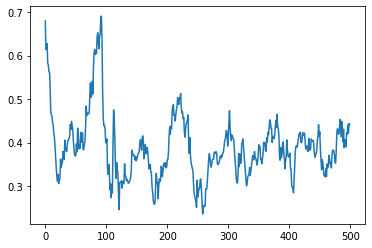

In [ ]:
re = []
for x,y in zip(Real_X, Surr_X):
    x = x.squeeze()
    y = y.squeeze()
    e = torch.norm(x - y)/torch.norm(x)
    re.append(e)
plt.plot(re)

### Make Movie

In [ ]:
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimati
from matplotlib import animation, rc
def create_1_channel_movie(im,outfile='sim.mp4',title='surrogate            simulation'):
    ti = 0
    u_mx = 255 #np.max(np.abs(Xrgb))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    cmap = plt.cm.ocean
    img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
    #plt.show()
    
    # initialization function: plot the background of each frame
    def init():
        img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)

    # animation function. This is called sequentially
    def animate(i):
        img = ax.imshow(im[i].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)


    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(im), interval=20, blit=True)
    anim.save(outfile, fps=30, extra_args=['-vcodec', 'libx264'])

In [ ]:
Xrgb = torch.cat([Surr_X_img, Real_X_img], dim=3)
Xrgb.shape

In [ ]:
outGif = '{}.gif'.format(versionName)
create_1_channel_movie(Xrgb.detach().numpy(),outfile=outGif)

In [ ]:
from IPython.display import Image
Image(filename=outGif)

In [ ]:
torch.prod(torch.tensor([3,5]))

tensor(15)

## Stats

/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


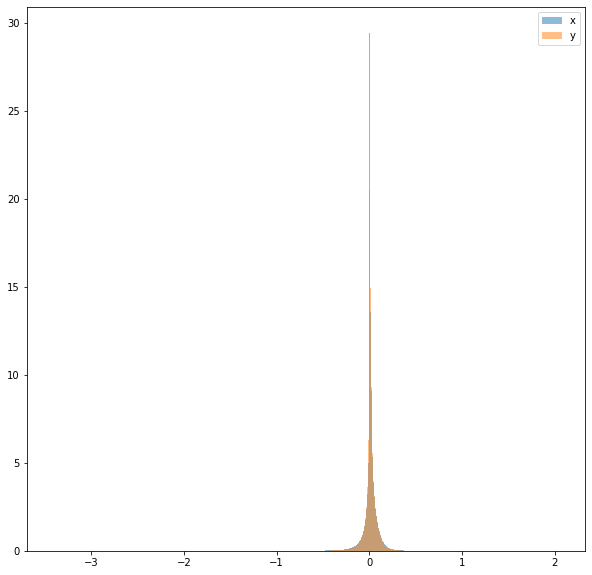

In [ ]:
x = Real_X.flatten()
y = Surr_X.flatten()
bins = np.linspace(x.min(), x.max(), 1000)
plt.figure(figsize=(10,10))
plt.hist(x, bins, alpha=0.5, label='x', normed=True)
plt.hist(y, bins, alpha=0.5, label='y', normed=True)
plt.legend(loc='upper right')
plt.show()

In [ ]:
def printStats(X):
    X  = np.array(X)
    mu = X.mean()
    sig = X.std()
    mx = X.max()
    mn = X.min()
    print('mu: {}, std: {}, mx: {}, mn: {}'.format(mu,sig,mx,mn))
    return mu,sig,mx,mn

In [ ]:
a = printStats(Real_X.flatten())
b = printStats(Surr_X.flatten())

mu: 0.008976921439170837, std: 0.08528874814510345, mx: 2.051384449005127, mn: -3.421556234359741
mu: 0.009030378423631191, std: 0.07568173855543137, mx: 1.1899173259735107, mn: -1.4470993280410767
